<a href="https://colab.research.google.com/github/ssnirgudkar/Home-AIML/blob/main/pspnet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Encoder - se_resnext50_32x4d, Decoder - FPN, 40 epochs. FPN = next generation pspnet 

https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

** our masked image is gray scale with 1 channel (height * width*channel=1). and the pixel values are equal to the class ids. Each pixle value is only 1 value and not (a*b*c). The CV2.imread, with a flag od 0 that reads it as a gray scalae does not work for our images although it works for the other dataset

## image size: (256, 320) #it's height and width

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user

In [ ]:
!pip uninstall -y segmentation-models-pytorch

In [ ]:
!git clone https://github.com/Cadene/pretrained-models.pytorch.git
!git clone https://github.com/qubvel/segmentation_models.pytorch
!git clone https://github.com/alexgkendall/SegNet-Tutorial

In [ ]:
#!pip install -U segmentation-models-pytorch albumentations --user
#!pip uninstall -y segmentation-models-pytorch
#!pip install segmentation_models_pytorch

!pip install git+https://github.com/IvyGongoogle/pretrained-models.pytorch
!pip install git+https://github.com/lukemelas/EfficientNet-PyTorch


In [ ]:
#!pip install efficientnet-pytorch
#!pip install pretrainedmodels 

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

# Restart Runtime now

In [1]:
import torch
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = '/content/drive/MyDrive/pspdata'
#DATA_DIR = './data/CamVid/'
# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [7]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    #0 - sky(d.blue). 1 - water(l.blue).   2 - bridge(yellow).   3 - obstacle(purple).  4- living ob(green).  
    #                5- backgnd (orange). 6 - self(pink)
    
    CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
                  
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        #mask1 = cv2.imread(self.masks_fps[1], cv2.IMREAD_UNCHANGED)
        #print("true value of image", np.unique(mask1))
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #HAD TO CHANGE FLAG 0 TO IM_READ_UNCHANGED BELOW as it was not reading the pixel values otherwise 
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        #print ("masked image values", mask[0])
        #print ("masked shape values", mask.shape)
        #print("masked unique values", np.unique(mask))
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

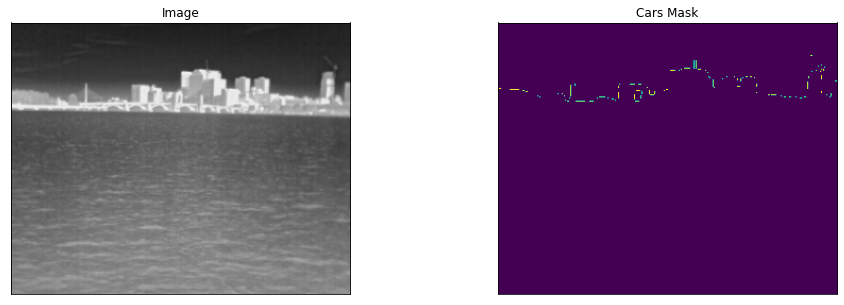

In [8]:
# Lets look at data we have. it can only put 1 class at a time 

dataset = Dataset(x_train_dir, y_train_dir, classes=['obstacle'])
#print("mask array" pill_to_array("/content/drive/MyDrive/pspdata/trainannot/1571161258.414889_1.png"))
image, mask = dataset[1] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [9]:
import albumentations as albu

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

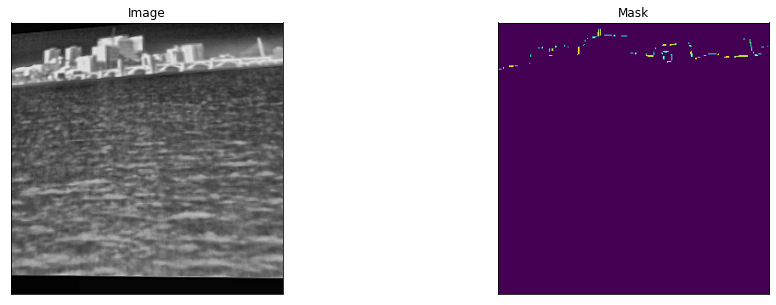

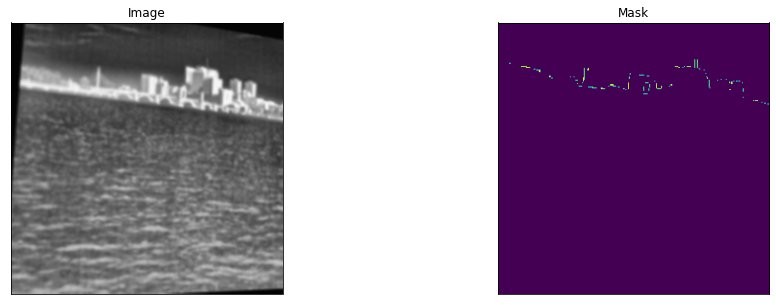

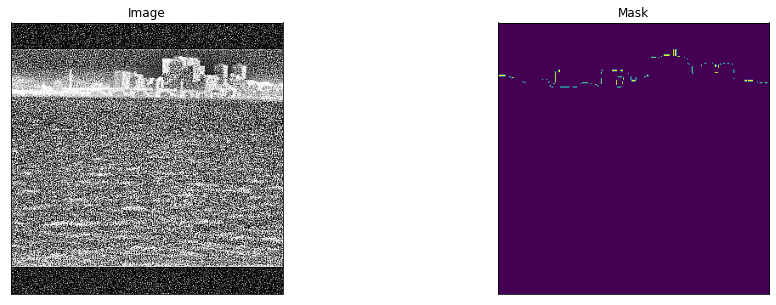

In [11]:
#### Visualize resulted augmented images and masks - thows error after 1st picture. this may not be needed though

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['obstacle'],
)

# same image with different random transforms
#for i in range(3):  (Had to comment this out as i only have 1 image. will remove during actual training)
for i in range(3):
   image, mask = augmented_dataset[1]
   visualize(image=image, mask=mask.squeeze(-1))

In [12]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
#DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [13]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=12) - used for running iwth 1 image
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

In [14]:

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    #device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    #device=DEVICE,
    verbose=True,
)

In [16]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Models/pspnet/pspnet-pytorch/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/54 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 54/54 [00:39<00:00,  1.38it/s, dice_loss - 0.9614, iou_score - 0.01966]
Model saved!

Epoch: 1
valid: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s, dice_loss - 0.9614, iou_score - 0.01966]

Epoch: 2
valid: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s, dice_loss - 0.9614, iou_score - 0.01966]

Epoch: 3
valid: 100%|██████████| 54/54 [00:37<00:00,  1.45it/s, dice_loss - 0.9614, iou_score - 0.01966]

Epoch: 4
valid: 100%|██████████| 54/54 [00:36<00:00,  1.47it/s, dice_loss - 0.9613, iou_score - 0.01966]

Epoch: 5
valid: 100%|██████████| 54/54 [00:37<00:00,  1.45it/s, dice_loss - 0.4288, iou_score - 0.4015]
Model saved!

Epoch: 6
valid: 100%|██████████| 54/54 [00:36<00:00,  1.49it/s, dice_loss - 0.4183, iou_score - 0.4107]
Model saved!

Epoch: 7
valid: 100%|██████████| 54/54 [00:36<00:00,  1.48it/s, dice_loss - 0.4145, iou_score - 0.4143]
Model saved!

Epoch: 8
valid: 100%|██████████| 54/54 [00:37<00:00,  1.44it/s, dice_loss - 0.4096, iou_score - 0.4194]
Model sa

In [17]:
best_model = torch.load('/content/drive/MyDrive/Models/pspnet/pspnet-pytorch/best_model.pth')

In [67]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    #x_train_dir,
    #y_train_dir,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    
)

test_dataloader = DataLoader(test_dataset)

In [68]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    #device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 18/18 [00:12<00:00,  1.50it/s, dice_loss - 0.3666, iou_score - 0.4644]


In [69]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    #x_train_dir, y_train_dir, 
    classes=CLASSES,
    
)

x shape = torch.Size([1, 3, 384, 480])
(7, 384, 480)
(7, 384, 480)


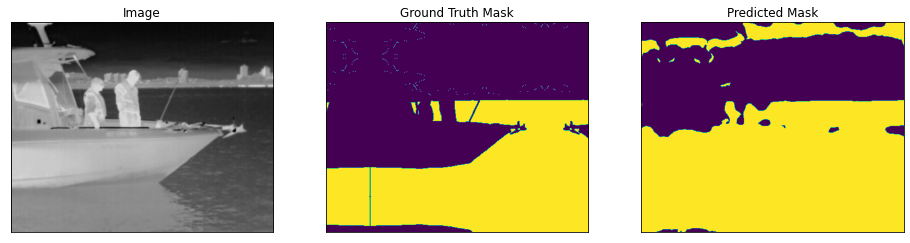

x shape = torch.Size([1, 3, 384, 480])
(7, 384, 480)
(7, 384, 480)


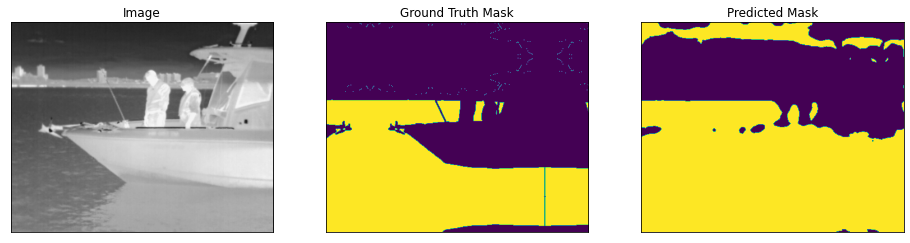

x shape = torch.Size([1, 3, 384, 480])
(7, 384, 480)
(7, 384, 480)


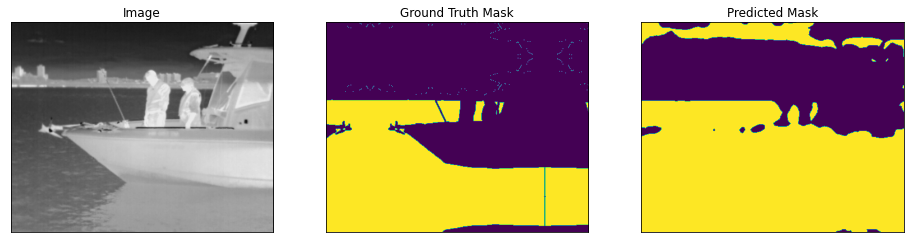

x shape = torch.Size([1, 3, 384, 480])
(7, 384, 480)
(7, 384, 480)


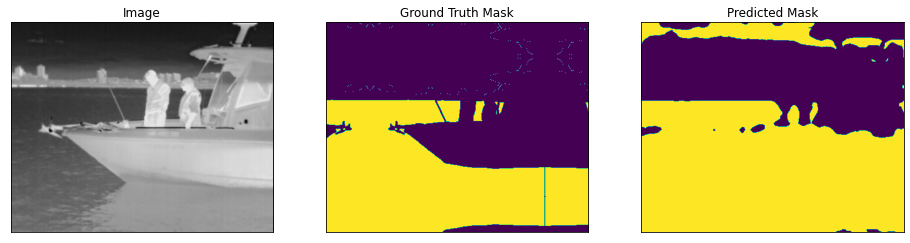

x shape = torch.Size([1, 3, 384, 480])
(7, 384, 480)
(7, 384, 480)


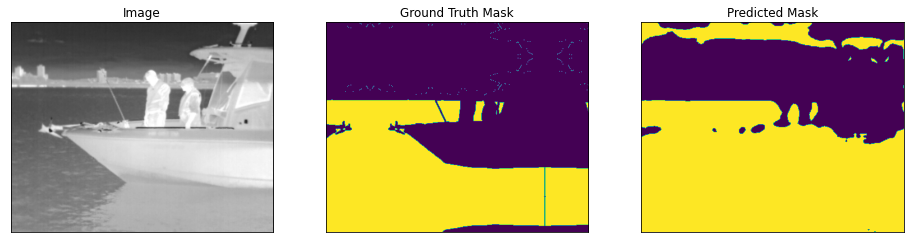

In [78]:
#CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
import numpy as np 
DEVICE = 'gpu'
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]

     #image_vis = test_dataset_vis[10][0].astype('uint8')
    #image, gt_mask = test_dataset[10]
    

    gt_mask = gt_mask.squeeze()
    
    #x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #print(pr_mask[0])
    print("x shape = {0}".format(x_tensor.shape))
    print (pr_mask.shape)
    print (gt_mask.shape)
    
    #print(np.unique(pr_mask))
    #print(np.unique(gt_mask))
    #print(np.unique(image_vis))

    

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[1], 
        predicted_mask=pr_mask[1]
    )


(256, 320, 1)


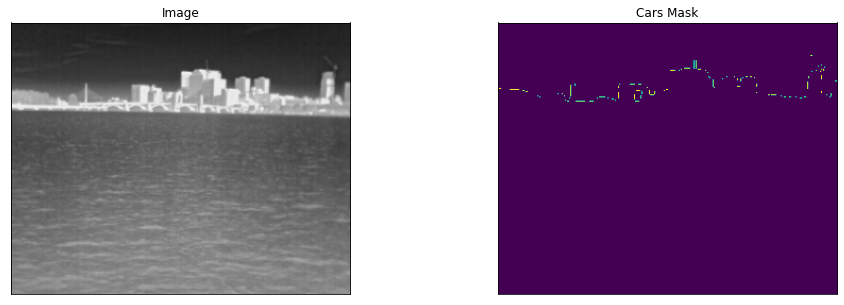

In [36]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['obstacle'])
#print("mask array" pill_to_array("/content/drive/MyDrive/pspdata/trainannot/1571161258.414889_1.png"))
image, mask = dataset[1] # get some sample
print(mask.shape)
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)